# **1. Recommendation sytem**

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('vodclickstream_uk_movies_03.csv')

Looking at the data, you can see that there is data available for each user for the movies the user clicked on. Gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks.

## **1.1 Gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks.**

In [5]:
dataset.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


Replace 'NOT AVAILABLE' with the corresponding genres based on the title

In [3]:
title_genre_mapping = dataset[dataset['genres'] != 'NOT AVAILABLE'][[
    'title', 'genres']].drop_duplicates().set_index('title')['genres'].to_dict()

dataset['genres'] = dataset.apply(
    lambda row: title_genre_mapping.get(row['title'], row['genres']), axis=1)

In [4]:
# Group, count, sort
user_counts = dataset.groupby(
    ['user_id', 'title', 'genres'])['title'].count().reset_index(name='title_count')
user_counts = user_counts.sort_values(
    ['user_id', 'title_count'], ascending=[True, False])

# Store the top 10 titles and genres for each user
top10_dataset = user_counts.groupby('user_id').head(10)
top10_dataset = top10_dataset.groupby('user_id').agg(
    {'title': list, 'genres': list}).reset_index()

# Remove duplicates in 'genres'
top10_dataset['genres'] = top10_dataset['genres'].apply(lambda x: list(set(x)))

# Convert list to string
top10_dataset['title'] = top10_dataset['title'].apply(lambda x: ', '.join(x))
top10_dataset['genres'] = top10_dataset['genres'].apply(lambda x: ', '.join(x))

top10_dataset.head()

,user_id,title,genres
0,00004e2862,Hannibal,"Crime, Drama, Thriller"
1,000052a0a0,"Looper, Frailty, Jumanji, Resident Evil, Ant-M...","Action, Adventure, Comedy, Sci-Fi, Action, Com..."
2,000090e7c8,Mute,"Mystery, Sci-Fi, Thriller"
3,000118a755,"From Dusk till Dawn (franchise), The Omen","NOT AVAILABLE, Horror"
4,000296842d,Black Mirror: Bandersnatch,"Drama, Mystery, Sci-Fi, Thriller"


## **1.2 Minhash Signatures**

Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket.

Since we build a recommendation system, we use User-Based Collaborative Filtering technique. We compare users by similar interests in genres. There are a few unique genres, we may use each genre as a shingle.

In [6]:
# Find unique genres
unique_genres = set()

dataset['genres_list'] = dataset.genres.apply(
    lambda row: [word.strip() for word in row.split(',')])
dataset['genres_list'] = dataset['genres_list'].apply(
    lambda genres_list: list(
        set(filter(lambda x: x != 'NOT AVAILABLE', genres_list)))
)
dataset['genres_list'].apply(
    lambda row: [unique_genres.add(value) for value in row])

print(unique_genres)
print('Unique genres count: ', len(unique_genres))

{'Documentary', 'Action', 'Drama', 'Horror', 'Romance', 'Biography', 'History', 'Film-Noir', 'Short', 'Adventure', 'Reality-TV', 'Music', 'Comedy', 'Thriller', 'Musical', 'Sci-Fi', 'Animation', 'Sport', 'Family', 'War', 'News', 'Talk-Show', 'Fantasy', 'Crime', 'Western', 'Mystery'}
Unique genres count:  26


In [7]:
# Create a dataframe with unique user_id and genres_list
top10_dataset['genres_list'] = top10_dataset.genres.apply(
    lambda row: [word.strip() for word in row.split(',')])
top10_dataset['genres_list'] = top10_dataset['genres_list'].apply(
    lambda genres_list: list(
        set(filter(lambda x: x != 'NOT AVAILABLE', genres_list)))
)
q1_df = top10_dataset.loc[:, ['user_id', 'genres_list']]
q1_df.head()

,user_id,genres_list
0,00004e2862,"[Drama, Thriller, Crime]"
1,000052a0a0,"[Comedy, Fantasy, Action, Horror, Thriller, Sc..."
2,000090e7c8,"[Mystery, Thriller, Sci-Fi]"
3,000118a755,[Horror]
4,000296842d,"[Mystery, Drama, Thriller, Sci-Fi]"


In [13]:
# Create a dictionary for mapping genres to rows
genre_to_row = {genre: i for i, genre in enumerate(unique_genres)}
genre_to_row

{'Documentary': 0,
 'Action': 1,
 'Drama': 2,
 'Horror': 3,
 'Romance': 4,
 'Biography': 5,
 'History': 6,
 'Film-Noir': 7,
 'Short': 8,
 'Adventure': 9,
 'Reality-TV': 10,
 'Music': 11,
 'Comedy': 12,
 'Thriller': 13,
 'Musical': 14,
 'Sci-Fi': 15,
 'Animation': 16,
 'Sport': 17,
 'Family': 18,
 'War': 19,
 'News': 20,
 'Talk-Show': 21,
 'Fantasy': 22,
 'Crime': 23,
 'Western': 24,
 'Mystery': 25}

Since we have 26 unique genres, to simulate permutations we construct 10 hash functions of type $h(x) = ax+b \text{ mod } 26$
To ensure that no collisions would occur, we need $a$ to be realively prime to 26

In [12]:
import math

# Function to find the first n values relatively prime to m
def find_rel_prime(n, m):
    rel_prime_values = []
    i = 1
    while len(rel_prime_values) < n:
        if math.gcd(i, m) == 1:
            rel_prime_values.append(i)
        i += 1
    return rel_prime_values

np.random.seed(911)

N = len(genre_to_row)

# We will produce 12 hash functions
n_rows = 12

a = find_rel_prime(n_rows, N)

# Generate random integers for the second column
b = np.random.randint(0, N, n_rows)

hash_param = np.column_stack((b, a))

# b+ax mod N
def hash_function(row):
    return (hash_param@np.array([1,row]))%N

print(hash_param)

[[11  1]
 [18  3]
 [ 8  5]
 [ 7  7]
 [17  9]
 [ 8 11]
 [ 4 15]
 [ 3 17]
 [ 7 19]
 [21 21]
 [21 23]
 [12 25]]


In [10]:
# initialize the signature matrix with infinity values
sig = np.full((n_rows, q1_df.shape[0]), np.inf)
for j, row in q1_df.iterrows():
    # iterate over each genre in a row
    for shingle in row['genres_list']:
        # get the value from dictionary
        initial_index = genre_to_row[shingle]
        # get the hash value (imitate permutation)
        permuted_index = hash_function(initial_index)
        sig[:, j] = np.minimum(sig[:, j], permuted_index)

sig = sig.astype(int)
pd.DataFrame(sig, columns=q1_df['user_id'])

/var/folders/yn/bvpk7j754919fx4tm6vc19y00000gn/T/ipykernel_1859/3535375087.py:12: RuntimeWarning: invalid value encountered in cast
  sig = sig.astype(int)


user_id,00004e2862,000052a0a0,000090e7c8,000118a755,000296842d,0002aab109,0002abf14f,0002d1c4b1,000499c2b6,00051f0e1f,...,fffb9ecb47,fffc1d209b,fffd345213,fffd4d1888,fffd6433d2,fffd9bf758,fffe7b777b,fffeac83be,ffff2c5f9e,ffffd36adf
0,8,0,0,14,0,8,13,0,1,0,...,2,0,3,7,21,8,0,2,10,8
1,5,1,5,1,5,2,4,2,2,2,...,2,2,2,2,22,9,5,2,2,9
2,18,1,3,23,3,7,2,5,1,1,...,2,1,1,2,6,3,5,3,3,18
3,12,0,0,2,0,12,9,8,3,8,...,0,5,3,5,25,0,8,0,0,12
4,4,0,4,18,4,9,1,21,5,0,...,1,0,20,0,3,8,4,6,0,9
5,1,1,17,15,4,1,0,10,2,3,...,0,1,3,0,14,1,4,1,8,1
6,8,2,15,23,8,1,8,2,2,2,...,1,0,2,2,24,4,8,1,2,8
7,4,0,12,2,11,4,11,24,0,0,...,3,0,0,11,17,3,11,1,3,4
8,2,0,6,12,6,1,5,1,1,0,...,1,0,1,0,15,2,6,1,0,2
9,8,0,0,6,0,10,1,13,2,2,...,0,2,2,1,23,0,8,0,0,10


## **1.3 Locality-Sensitive Hashing (LSH)**

Recommend at most five movies to the user to watch based on the movies clicked by similar users.

In [14]:
import collections

# Function to find candidate pairs using LSH
def candidate_pairs(sig, b):
    d = sig.shape[1]

    # split the signature matrix into bands
    bands = np.array_split(sig, b, axis=0)

    buckets = collections.defaultdict(set)

    # iterate over bands and hash each column into buckets
    for i, band in enumerate(bands):
        for j in range(d):
            # create a unique bucket_id
            bucket_id = tuple(list(band[:, j]) + [str(i)])
            buckets[bucket_id].add(j)

    # take only buckets with more than one value
    bucket_candidates = [
        bucket for bucket in buckets.values() if len(bucket) > 1]

    return bucket_candidates


def calculate_similarity(user_index, candidate_index):
    # extract the genres lists for the specified user and candidate
    genres_user = q1_df.genres_list.iloc[candidate_index]
    genres_candidate = q1_df.genres_list.iloc[user_index]

    # calculate the Jaccard similarity score between the two genres lists
    intersection = len(set(genres_user).intersection(set(genres_candidate)))
    union = len(set(genres_user).union(set(genres_candidate)))
    similarity = intersection / union if union != 0 else 0

    return similarity


def find_similar_users(candidate_pairs, user_id, df):
    # find the index of the current user in the DataFrame
    user_index = df.loc[df['user_id'] == user_id].index[0]

    # iterate over candidate pairs
    for bucket in candidate_pairs:
        if user_index in bucket:
            candidates = []

            # iterate over all users in the bucket
            for candidate_index in bucket - {user_index}:
                # calculate the similarity score
                current_score = calculate_similarity(
                    user_index, candidate_index)
                candidates.append((current_score, candidate_index))

            # sort candidates based on similarity scores and keep the top 2 candidates
            sorted_candidates = sorted(
                candidates, key=lambda x: x[0], reverse=True)[:2]

            # convert back to user IDs
            candidate_ids = [df.loc[candidate_index, 'user_id']
                             for _, candidate_index in sorted_candidates]

    return candidate_ids

In [15]:
# LSH with 3 bands of 4 rows each
pairs = candidate_pairs(sig, b=3)

target_user = q1_df.user_id[21]
print('Target user: ', target_user)

similar_users = find_similar_users(pairs, target_user, q1_df)
print('Similar users: ', similar_users)

Target user:  0008d919a5
Similar users:  ['016f61f44c', '38e51bcd15']


In [16]:
# user_counts dataframe contains counted titles for each user
all_recommendations = user_counts[user_counts['user_id'].isin(similar_users)]

first_user = similar_users[0]
first_user_movies = all_recommendations[all_recommendations['user_id'] == first_user]

second_user = similar_users[1]
second_user_movies = all_recommendations[all_recommendations['user_id'] == second_user]

all_recommendations

,user_id,title,genres,title_count
2785,016f61f44c,Pitch Perfect 2,"Comedy, Music",1
2786,016f61f44c,The Divergent Series: Insurgent,"Action, Adventure, Sci-Fi, Thriller",1
110341,38e51bcd15,Jurassic World,"Action, Adventure, Sci-Fi",5
110343,38e51bcd15,Taken 3,"Action, Thriller",3
110342,38e51bcd15,Pitch Perfect 2,"Comedy, Music",1


In [17]:
# find common titles
common_titles = set(all_recommendations[all_recommendations['user_id'] == first_user]['title']).intersection(
    set(all_recommendations[all_recommendations['user_id']
        == second_user]['title'])
)

# filter all_recommendations by common titles
recommendations_df = all_recommendations[all_recommendations['title'].isin(
    common_titles)]

# group by title, sum the counts and sort
recommendations_df = recommendations_df.groupby('title', as_index=False).sum()
recommendations_df = recommendations_df.sort_values(
    by='title_count', ascending=False)

recommendations_df = recommendations_df[['title']]

# loop through 1st and 2nd user movies, add titles if they are not there yet and if the length of df is less than 5
for _, row in first_user_movies.iterrows():
    if len(recommendations_df) >= 5:
        break
    if row['title'] not in recommendations_df['title'].values:
        recommendations_df = pd.concat([recommendations_df, pd.DataFrame(row[['title']]).transpose()])

for _, row in second_user_movies.iterrows():
    if len(recommendations_df) >= 5:
        break
    if row['title'] not in recommendations_df['title'].values:
        recommendations_df = pd.concat([recommendations_df, pd.DataFrame(row[['title']]).transpose()])

In [18]:
print(f"Recommended movies for user {target_user}:")
for i, title in enumerate(recommendations_df['title'], 1):
    print(f"{i}. {title}")

Recommended movies for user 0008d919a5:
1. Pitch Perfect 2
2. The Divergent Series: Insurgent
3. Jurassic World
4. Taken 3


# **2. Grouping Users together!**

## **2.1 Getting your data + feature engineering**

#### **2.1.1 Accessing the Dataset and Preprocessing it for the further analysis.**

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv("/content/vodclickstream_uk_movies_03.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [ ]:
df.head(5)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:

missing_values = df.isnull().sum()
print(missing_values)


Unnamed: 0      0
datetime        0
duration        0
title           0
genres          0
release_date    0
movie_id        0
user_id         0
dtype: int64


In [ ]:
# Removing rows with "NOT AVAILABLE" entries in 'genres' and 'release_date' from df
df = df[(df['genres'] != 'NOT AVAILABLE') & (df['release_date'] != 'NOT AVAILABLE')]
print("Shape of modified DataFrame:", df.shape)


Shape of modified DataFrame: (639842, 8)


In [ ]:
NA_counts = df[df == 'NOT AVAILABLE'].count()

columns_with_NA = NA_counts[NA_counts > 0].index
NA_counts[columns_with_NA]


Series([], dtype: int64)

In [ ]:
# Counting entries with duration of 0.0 seconds and empty entries (-1)
zero_duration_count = df[df['duration'] == 0.0].shape[0]
Empty_entries_count = df[df['duration']== -1].shape[0]

print(f"Number of entries with duration of 0.0 seconds: {zero_duration_count}")
print(f"Number of empty entries with duration : {Empty_entries_count}")

Number of entries with duration of 0.0 seconds: 284523
Number of empty entries with duration : 20808


In [ ]:
# Removing entries with duration of 0.0 seconds and -1 entries
df = df[df['duration'] != 0.0]
df = df[df['duration'] != -1]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334511 entries, 2 to 671732
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    334511 non-null  int64         
 1   datetime      334511 non-null  datetime64[ns]
 2   duration      334511 non-null  float64       
 3   title         334511 non-null  object        
 4   genres        334511 non-null  object        
 5   release_date  334511 non-null  object        
 6   movie_id      334511 non-null  object        
 7   user_id       334511 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 23.0+ MB


In [ ]:
df_filtered = df.copy()

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334511 entries, 2 to 671732
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    334511 non-null  int64         
 1   datetime      334511 non-null  datetime64[ns]
 2   duration      334511 non-null  float64       
 3   title         334511 non-null  object        
 4   genres        334511 non-null  object        
 5   release_date  334511 non-null  object        
 6   movie_id      334511 non-null  object        
 7   user_id       334511 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 23.0+ MB


#### **2.1.2 Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:**

a) Favorite genre (i.e., the genre on which the user spent the most time)

b) Average click duration

c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

e) Average time spent a day by the user (considering only the days he logs in)

In [ ]:
# a) Favorite genre (i.e., the genre on which the user spent the most time)
favorite_genre = df_filtered.groupby(['user_id', 'genres'])['duration'].sum().reset_index()
favorite_genre = favorite_genre.sort_values('duration', ascending=False).drop_duplicates('user_id')
favorite_genre = favorite_genre[['user_id', 'genres']].rename(columns={'genres': 'favorite_genre'})


In [ ]:
# b) Average click duration
average_click_duration = df_filtered.groupby('user_id')['duration'].mean().reset_index()
average_click_duration.rename(columns={'duration': 'average_click_duration'}, inplace=True)


In [ ]:
# c) Time of the day (Morning/Afternoon/Night) when the user spends the most time

df_filtered['hour'] = df['datetime'].dt.hour

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

df_filtered['time_of_day'] = df_filtered['hour'].apply(get_time_of_day)
time_of_day_most_spent = df_filtered.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()
time_of_day_most_spent = time_of_day_most_spent.sort_values('duration', ascending=False).drop_duplicates('user_id')
time_of_day_most_spent = time_of_day_most_spent[['user_id', 'time_of_day']]



In [ ]:
# d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

df_filtered['release_year'] = pd.to_datetime(df_filtered['release_date'], errors='coerce').dt.year
user_preference = df_filtered.groupby('user_id')['release_year'].max().reset_index()
user_preference['preference'] = user_preference['release_year'].apply(lambda x: 'Old Movie Lover' if x <= 2010 else 'Into Recent Stuff')
user_preference = user_preference[['user_id', 'preference']]


In [ ]:
# e) Average time spent a day by the user (considering only the days he logs in)

average_time_spent_per_day = df_filtered.groupby(['user_id', df_filtered['datetime'].dt.date])['duration'].sum().reset_index()
average_time_spent_per_day = average_time_spent_per_day.groupby('user_id')['duration'].mean().reset_index()
average_time_spent_per_day.rename(columns={'duration': 'average_time_spent_per_day'}, inplace=True)

In [ ]:
# Merging all the features

features = pd.merge(favorite_genre, average_click_duration, on='user_id', how='outer')
features = pd.merge(features, time_of_day_most_spent, on='user_id', how='outer')
features = pd.merge(features, user_preference, on='user_id', how='outer')
features = pd.merge(features, average_time_spent_per_day, on='user_id', how='outer')


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106591 entries, 0 to 106590
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     106591 non-null  object 
 1   favorite_genre              106591 non-null  object 
 2   average_click_duration      106591 non-null  float64
 3   time_of_day                 106591 non-null  object 
 4   preference                  106591 non-null  object 
 5   average_time_spent_per_day  106591 non-null  float64
dtypes: float64(2), object(4)
memory usage: 5.7+ MB


#### **2.1.3. Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).**

In [ ]:
# Feature 6: Total Clicks (Represents the total number of clicks made by the user)

total_clicks = df_filtered.groupby('user_id').size().reset_index(name='total_clicks')


In [ ]:
# Feature 7: Distinct Genres Count (Indicates the number of distinct genres clicked by the user)
distinct_genres_count = df_filtered.groupby('user_id')['genres'].nunique().reset_index(name='distinct_genres_count')


In [ ]:
# Feature 8: Longest Session Duration (Represents the longest duration of a single click session for the user)
longest_session_duration = df_filtered.groupby('user_id')['duration'].max().reset_index(name='longest_session_duration')


In [ ]:
# Feature 9: Shortest Session Duration (Represents the shortest duration of a single click session for the user)
shortest_session_duration = df_filtered.groupby('user_id')['duration'].min().reset_index(name='shortest_session_duration')


In [ ]:
# Extracting day of the week from the 'datetime' column
df_filtered['day_of_week'] = df_filtered['datetime'].dt.day_name()

In [ ]:
# Feature 10: Weekday vs Weekend Activity (Represents the ratio between weekday and weekend)

df_filtered['is_weekday'] = df_filtered['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
weekday_activity_ratio = df_filtered.groupby('user_id')['is_weekday'].mean().reset_index(name='weekday_activity_ratio')


In [ ]:
# Feature 11: Days Active (Represents the number of days the user has been active.)

days_active = df_filtered.groupby('user_id')['datetime'].apply(lambda x: x.dt.date.nunique()).reset_index(name='days_active')


In [ ]:
# Extract day of the week from 'datetime'
df_filtered['day_of_week'] = df_filtered['datetime'].dt.day_name()

# Feature 12: Most Active Day of the Week (Represents the most active day of the week for the user)

most_active_day = df_filtered.groupby(['user_id', 'day_of_week'])['duration'].sum().reset_index(name='total_duration')
most_active_day = most_active_day.loc[most_active_day.groupby('user_id')['total_duration'].idxmax()]
most_active_day = most_active_day[['user_id', 'day_of_week']]



In [ ]:
# Feature 13: Average Clicks per Day ( Represents the average number of clicks per day for the user.)

average_clicks_per_day = total_clicks['total_clicks'] / days_active['days_active']
average_clicks_per_day = pd.DataFrame({'user_id': total_clicks['user_id'], 'average_clicks_per_day': average_clicks_per_day})

In [ ]:
# Feature 14: Weekend Clicks Ratio (Represents the ratio of clicks that occurred on weekends for the user)

df_filtered['is_weekend'] = df_filtered['day_of_week'].isin(['Saturday', 'Sunday'])
weekend_clicks_ratio = df_filtered.groupby('user_id')['is_weekend'].mean().reset_index(name='weekend_clicks_ratio')


In [ ]:
# Feature 15: Evening Clicks Ratio (Represents the ratio of clicks that occurred in the evening for the user)

df_filtered['is_evening'] = df_filtered['hour'].between(18, 23)
evening_clicks_ratio = df_filtered.groupby('user_id')['is_evening'].mean().reset_index(name='evening_clicks_ratio')


In [ ]:
# Merge all additional features into a single DataFrame

additional_features = pd.merge(total_clicks, distinct_genres_count, on='user_id')
additional_features = pd.merge(additional_features, longest_session_duration, on='user_id')
additional_features = pd.merge(additional_features, shortest_session_duration, on='user_id')
additional_features = pd.merge(additional_features, weekday_activity_ratio, on='user_id')
additional_features = pd.merge(additional_features, days_active, on='user_id')
additional_features = pd.merge(additional_features, most_active_day, on='user_id')
additional_features = pd.merge(additional_features, average_clicks_per_day, on='user_id')
additional_features = pd.merge(additional_features, weekend_clicks_ratio, on='user_id')
additional_features = pd.merge(additional_features, evening_clicks_ratio, on='user_id')


In [ ]:
additional_features.head(2)

,user_id,total_clicks,distinct_genres_count,longest_session_duration,shortest_session_duration,weekday_activity_ratio,days_active,day_of_week,average_clicks_per_day,weekend_clicks_ratio,evening_clicks_ratio
0,000052a0a0,14,9,7857.0,600.0,0.714286,8,Friday,1.75,0.285714,0.714286
1,000296842d,4,1,62860.0,600.0,0.750000,2,Monday,2.00,0.250000,0.500000


In [ ]:
# merging the previous 5 features along with this 10 features to get the 15 features for each userID in total

New_features = pd.merge(features,additional_features, on='user_id')

In [ ]:
New_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106591 entries, 0 to 106590
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     106591 non-null  object 
 1   favorite_genre              106591 non-null  object 
 2   average_click_duration      106591 non-null  float64
 3   time_of_day                 106591 non-null  object 
 4   preference                  106591 non-null  object 
 5   average_time_spent_per_day  106591 non-null  float64
 6   total_clicks                106591 non-null  int64  
 7   distinct_genres_count       106591 non-null  int64  
 8   longest_session_duration    106591 non-null  float64
 9   shortest_session_duration   106591 non-null  float64
 10  weekday_activity_ratio      106591 non-null  float64
 11  days_active                 106591 non-null  int64  
 12  day_of_week                 106591 non-null  object 
 13  average_clicks

In [ ]:
missing_values =  New_features.isnull().sum()
print(missing_values)


user_id                       0
favorite_genre                0
average_click_duration        0
time_of_day                   0
preference                    0
average_time_spent_per_day    0
total_clicks                  0
distinct_genres_count         0
longest_session_duration      0
shortest_session_duration     0
weekday_activity_ratio        0
days_active                   0
day_of_week                   0
average_clicks_per_day        0
weekend_clicks_ratio          0
evening_clicks_ratio          0
dtype: int64


In [ ]:
New_features.head(1)

,user_id,favorite_genre,average_click_duration,time_of_day,preference,average_time_spent_per_day,total_clicks,distinct_genres_count,longest_session_duration,shortest_session_duration,weekday_activity_ratio,days_active,day_of_week,average_clicks_per_day,weekend_clicks_ratio,evening_clicks_ratio
0,322abe045c,"Action, Biography, Crime, Drama",2.354187e+06,Morning,Into Recent Stuff,2648460.625,9,4,18237253.0,2.0,1.0,8,Thursday,1.125,0.0,0.0


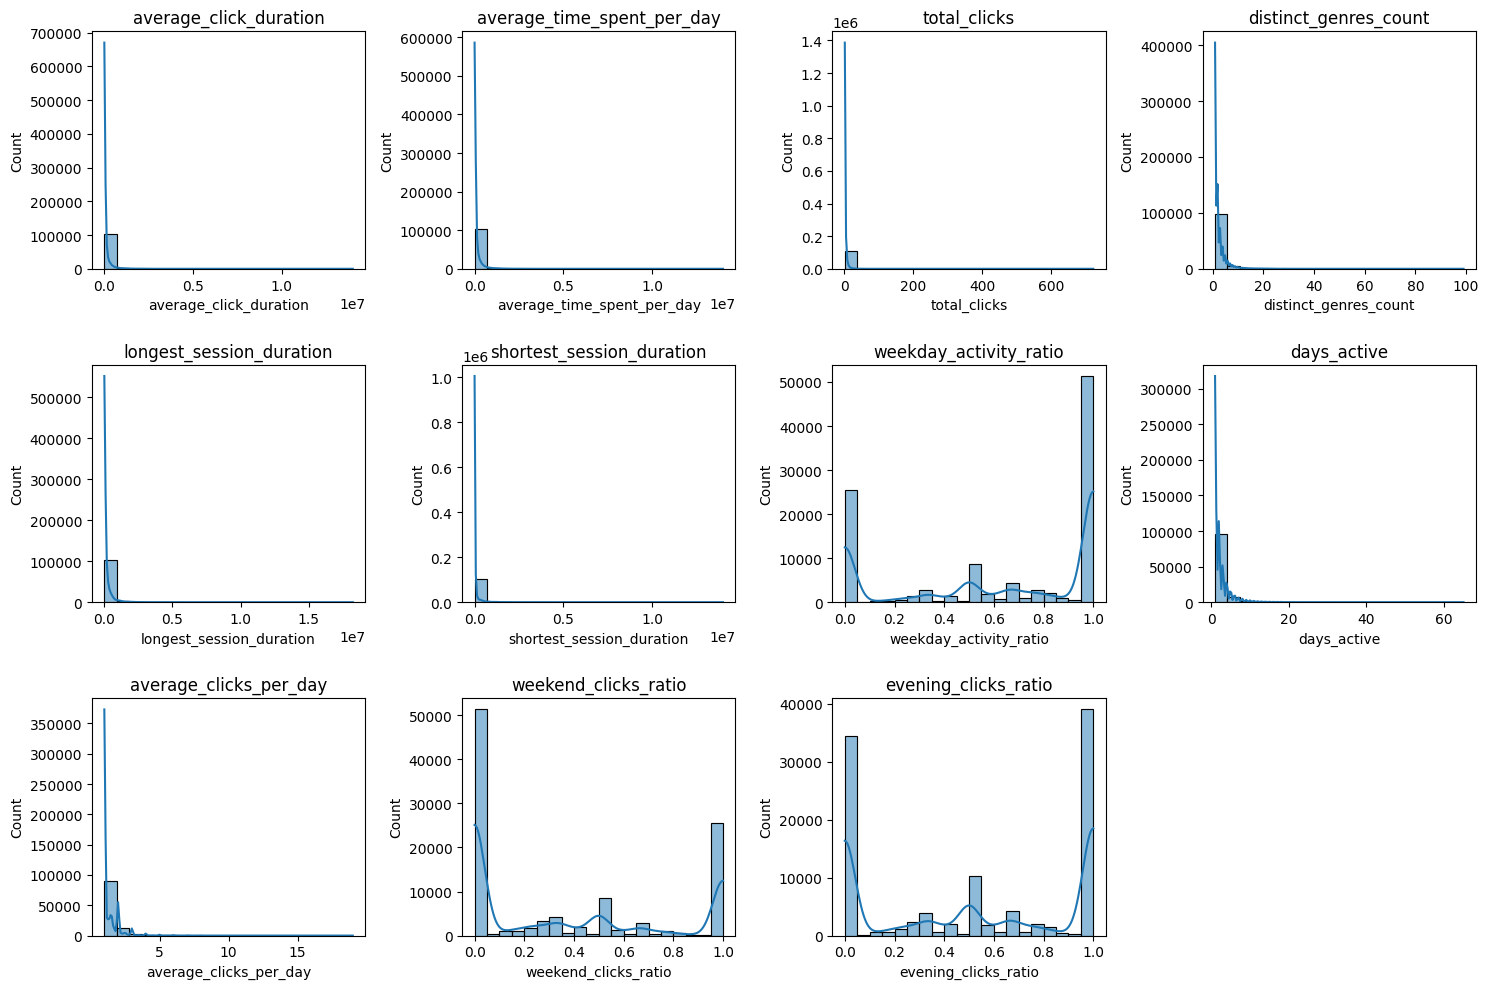

In [ ]:
# Visulaizing the Numerical features to see the distributions

import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = New_features.select_dtypes(include=['float64', 'int64']).columns


fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)


for i, feature in enumerate(numerical_features):
    row, col = divmod(i, 4)
    sns.histplot(New_features[feature], bins=20, kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)


for i in range(len(numerical_features), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


From the above plots , it can be seen that the skewedness are there for majority of the features in our dataframe , so before proceeding with the further analysis normalization is needed for the features. The next section is all about the normalization and Dimensionality reduction.

## **2.2 Choose your features (variables)!**

Normalization, or scaling, is a critical data preprocessing technique that transforms features to a common scale to prevent larger magnitudes from overshadowing others during analysis. The decision to normalize depends on the algorithms used and data characteristics. It is beneficial for scale-sensitive algorithms like k-Nearest Neighbors and gradient descent-based methods, aiding in faster convergence and improved model performance. However, normalization may be unnecessary or even detrimental for tree-based algorithms like Decision Trees and Random Forests, which are generally insensitive to feature scale. If interpretability is a priority and the scale has meaningful units, avoiding normalization helps retain the original scale of features. The approach involves assessing the impact of scale on algorithm performance and applying normalization techniques like Min-Max Scaling, Standard Scaling, or Robust Scaling if needed, while preserving data integrity. In conclusion, normalization is valuable for aligning feature scales, but its application depends on the chosen algorithms and data characteristics.

In [ ]:
from sklearn.preprocessing import StandardScaler

dfn = New_features.copy()

numerical_features = ['average_click_duration', 'average_time_spent_per_day', 'total_clicks',
                      'distinct_genres_count', 'longest_session_duration', 'shortest_session_duration',
                      'weekday_activity_ratio', 'days_active', 'average_clicks_per_day',
                      'weekend_clicks_ratio', 'evening_clicks_ratio']


scaler = StandardScaler()

# Normalize numerical features
dfn[numerical_features] = scaler.fit_transform(dfn[numerical_features])


print(dfn[numerical_features].head(1))


   average_click_duration  average_time_spent_per_day  total_clicks  \
0                  9.1734                    9.623559      1.055731   

   distinct_genres_count  longest_session_duration  shortest_session_duration  \
0               0.587746                  51.55349                  -0.255914   

   weekday_activity_ratio  days_active  average_clicks_per_day  \
0                0.873653     2.406489               -0.274736   

   weekend_clicks_ratio  evening_clicks_ratio  
0             -0.873653             -1.222086  


In [ ]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer


categorical_features = ['time_of_day', 'preference', 'day_of_week', 'favorite_genre']


mlb = MultiLabelBinarizer()

# Apply MultiLabelBinarizer to 'favorite_genre'
df_genre_encoded = pd.DataFrame(mlb.fit_transform(dfn['favorite_genre'].str.split(', ')),
                                columns=mlb.classes_, index=dfn.index)

dfn = pd.concat([dfn, df_genre_encoded], axis=1)
dfn = dfn.drop('favorite_genre', axis=1)

encoder = OneHotEncoder()


df_encoded = pd.DataFrame(encoder.fit_transform(dfn[categorical_features[:-1]]).toarray(),
                          columns=encoder.get_feature_names_out(categorical_features[:-1]))

dfn = pd.concat([dfn, df_encoded], axis=1)
dfn = dfn.drop(categorical_features[:-1], axis=1)

print(dfn.head(1))


      user_id  average_click_duration  average_time_spent_per_day  \
0  322abe045c                  9.1734                    9.623559   

   total_clicks  distinct_genres_count  longest_session_duration  \
0      1.055731               0.587746                  51.55349   

   shortest_session_duration  weekday_activity_ratio  days_active  \
0                  -0.255914                0.873653     2.406489   

   average_clicks_per_day  ...  time_of_day_Night  \
0               -0.274736  ...                0.0   

   preference_Into Recent Stuff  preference_Old Movie Lover  \
0                           1.0                         0.0   

   day_of_week_Friday  day_of_week_Monday  day_of_week_Saturday  \
0                 0.0                 0.0                   0.0   

   day_of_week_Sunday  day_of_week_Thursday  day_of_week_Tuesday  \
0                 0.0                   1.0                  0.0   

   day_of_week_Wednesday  
0                    0.0  

[1 rows x 50 columns]


In [ ]:
dfn.columns

Index(['user_id', 'average_click_duration', 'average_time_spent_per_day',
       'total_clicks', 'distinct_genres_count', 'longest_session_duration',
       'shortest_session_duration', 'weekday_activity_ratio', 'days_active',
       'average_clicks_per_day', 'weekend_clicks_ratio',
       'evening_clicks_ratio', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western', 'time_of_day_Afternoon',
       'time_of_day_Morning', 'time_of_day_Night',
       'preference_Into Recent Stuff', 'preference_Old Movie Lover',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday'],
      dtype='object')

In [ ]:
from sklearn.decomposition import PCA

numerical_features_for_pca = ['average_click_duration', 'average_time_spent_per_day', 'total_clicks',
                               'distinct_genres_count', 'longest_session_duration', 'shortest_session_duration',
                               'weekday_activity_ratio', 'days_active', 'average_clicks_per_day',
                               'weekend_clicks_ratio', 'evening_clicks_ratio']

# Creating a DataFrame with only numerical features
df_numerical = dfn[numerical_features_for_pca]

pca = PCA(random_state=42)
pca.fit(df_numerical)  # X is your data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()


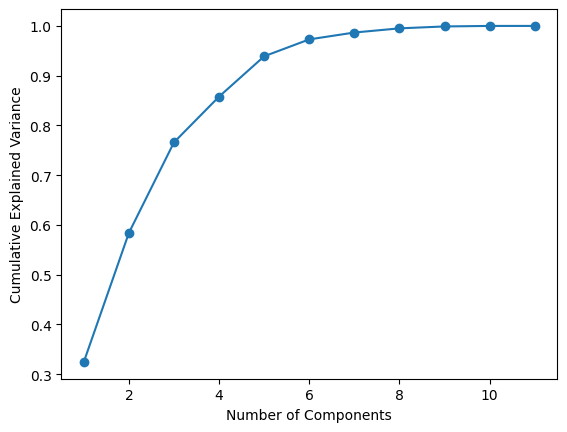

In [ ]:
# Plotting  cumulative explained variance with a marker for the chosen number of components
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
print("Explained Variance Ratios:", explained_variance_ratio)


Explained Variance Ratios: [3.24664089e-01 2.59461964e-01 1.81950067e-01 9.18870640e-02
 8.10169748e-02 3.39755816e-02 1.37818918e-02 8.36665385e-03
 3.84605439e-03 1.04966019e-03 7.25989230e-34]


- Upon visually inspecting the plot and noticeing that the explained variance starts to level off or reaches a plateau after 6 components), it suggests that these components capture the majority of the variance. Based on our observation, we choose n_components = 6 for our PCA analysis. This means that we will retain three principal components, which collectively explain a significant portion of the variance in our dataset.

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=6,random_state=42)  # Retain 95% of the variance and number of components is 6 for the analysis.

df_pca_result = pd.DataFrame(pca.fit_transform(df_numerical), columns=[f'PCA_{i}' for i in range(1, pca.n_components_ + 1)])

print(df_pca_result.head())


        PCA_1      PCA_2     PCA_3     PCA_4     PCA_5      PCA_6
0   32.366794  12.778736 -0.490123  1.167793 -0.823221  35.826071
1  103.127987  16.630449  0.352278  2.054051  2.416002 -14.308534
2   84.366739  13.444773  0.046433  1.490906  2.011927 -11.731185
3   28.487305   8.016400 -0.659837  1.575778 -0.142441  21.401240
4   72.483476  11.473167 -0.032412  3.325830  0.933824 -10.080605


In [ ]:
pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 4.4 MB/s eta 0:00:00


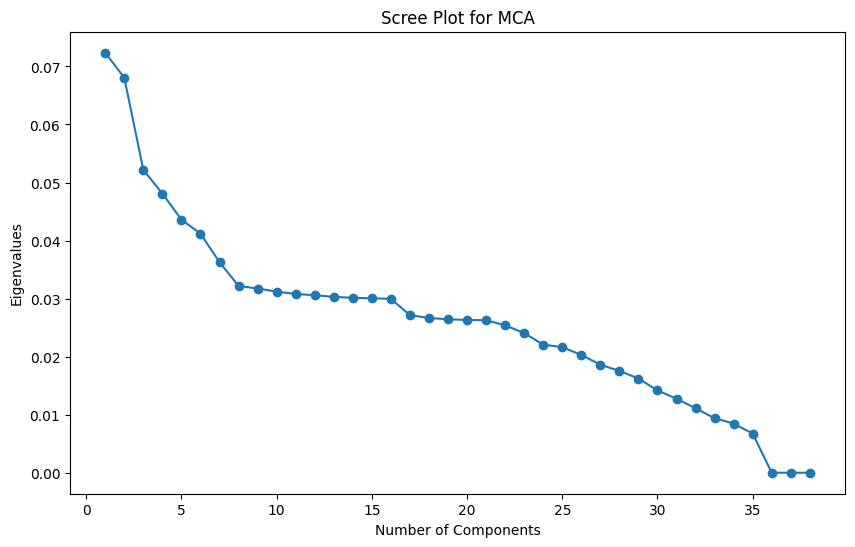

In [ ]:
from prince import MCA
import matplotlib.pyplot as plt

categorical_features = dfn.columns.difference(numerical_features + ['user_id']).tolist()
categorical_df = dfn[categorical_features].copy()


mca = MCA(n_components=38,random_state=42)
mca.fit(categorical_df)

# Plot the eigenvalues manually
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mca.eigenvalues_) + 1), mca.eigenvalues_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot for MCA')
plt.show()



In [ ]:
print("Eigenvalues:", mca.eigenvalues_)

Eigenvalues: [7.23596911e-02 6.80483958e-02 5.21639276e-02 4.80992501e-02
 4.36054166e-02 4.11934073e-02 3.62774451e-02 3.21862845e-02
 3.17340370e-02 3.12032577e-02 3.08038249e-02 3.05790694e-02
 3.03047347e-02 3.01307552e-02 3.00482690e-02 2.99544044e-02
 2.71551126e-02 2.66559642e-02 2.64437104e-02 2.63145538e-02
 2.62697541e-02 2.53841452e-02 2.40678121e-02 2.20581208e-02
 2.16380929e-02 2.02879101e-02 1.86135840e-02 1.75389960e-02
 1.62301510e-02 1.41809698e-02 1.27489093e-02 1.11007252e-02
 9.39974937e-03 8.46402119e-03 6.75554758e-03 3.40775892e-31
 8.32304015e-34 6.82123186e-34]


- Upon Careful observation , The eigenvalues start to become small after the 12th component. This indicates that the first 12th components capture most of the variation in the data, and that the remaining components are not as important. Therefore, we consider retaining the first 12th components for our analysis. This will allow us to capture most of the variation in the data while also keeping our analysis relatively simple and interpretable.

In [ ]:
from prince import MCA

categorical_features = dfn.columns.difference(numerical_features + ['user_id']).tolist()
mca = MCA(n_components=12,random_state=42)
df_categorical_mca = mca.fit_transform(dfn[categorical_features])
df_categorical_mca.columns = [f'MCA_{i}' for i in range(df_categorical_mca.shape[1])]
print(df_categorical_mca.head(3))



      MCA_0     MCA_1     MCA_2     MCA_3     MCA_4     MCA_5     MCA_6  \
0 -0.294993  0.005896 -0.032264  0.260207  0.226598  0.075707  0.022587   
1 -0.253477 -0.310303  0.175878 -0.138782 -0.111262  0.114283  0.162588   
2  0.021521  0.193886 -0.129376 -0.231778 -0.165098  0.241647  0.138216   

      MCA_7     MCA_8     MCA_9    MCA_10    MCA_11  
0 -0.277784  0.308910 -0.299755  0.274110  0.193494  
1  0.066595 -0.167754 -0.011011 -0.082305  0.066988  
2 -0.005906 -0.213868 -0.138851 -0.145326  0.438121  


In [ ]:
# Concatenating the results

df_combined = pd.concat([df_pca_result , df_categorical_mca], axis=1)

# Display the first few rows of the combined dataset
print(df_combined.head(1))

       PCA_1      PCA_2     PCA_3     PCA_4     PCA_5      PCA_6     MCA_0  \
0  32.366794  12.778736 -0.490123  1.167793 -0.823221  35.826071 -0.294993   

      MCA_1     MCA_2     MCA_3     MCA_4     MCA_5     MCA_6     MCA_7  \
0  0.005896 -0.032264  0.260207  0.226598  0.075707  0.022587 -0.277784   

     MCA_8     MCA_9   MCA_10    MCA_11  
0  0.30891 -0.299755  0.27411  0.193494  


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106591 entries, 0 to 106590
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PCA_1   106591 non-null  float64
 1   PCA_2   106591 non-null  float64
 2   PCA_3   106591 non-null  float64
 3   PCA_4   106591 non-null  float64
 4   PCA_5   106591 non-null  float64
 5   PCA_6   106591 non-null  float64
 6   MCA_0   106591 non-null  float64
 7   MCA_1   106591 non-null  float64
 8   MCA_2   106591 non-null  float64
 9   MCA_3   106591 non-null  float64
 10  MCA_4   106591 non-null  float64
 11  MCA_5   106591 non-null  float64
 12  MCA_6   106591 non-null  float64
 13  MCA_7   106591 non-null  float64
 14  MCA_8   106591 non-null  float64
 15  MCA_9   106591 non-null  float64
 16  MCA_10  106591 non-null  float64
 17  MCA_11  106591 non-null  float64
dtypes: float64(18)
memory usage: 14.6 MB


In [ ]:
df_combined = df_combined.astype('float32')
#reducing the float size so as to reduce the overall dataframe size

In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106591 entries, 0 to 106590
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PCA_1   106591 non-null  float32
 1   PCA_2   106591 non-null  float32
 2   PCA_3   106591 non-null  float32
 3   PCA_4   106591 non-null  float32
 4   PCA_5   106591 non-null  float32
 5   PCA_6   106591 non-null  float32
 6   MCA_0   106591 non-null  float32
 7   MCA_1   106591 non-null  float32
 8   MCA_2   106591 non-null  float32
 9   MCA_3   106591 non-null  float32
 10  MCA_4   106591 non-null  float32
 11  MCA_5   106591 non-null  float32
 12  MCA_6   106591 non-null  float32
 13  MCA_7   106591 non-null  float32
 14  MCA_8   106591 non-null  float32
 15  MCA_9   106591 non-null  float32
 16  MCA_10  106591 non-null  float32
 17  MCA_11  106591 non-null  float32
dtypes: float32(18)
memory usage: 7.3 MB


In [ ]:
df_combined.to_csv('dimensionality_reduced_df.csv', index=False)

## **2.3 Clustering!**

#### **2.3.1. Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.**


- For easy implementation of the K mean Clustering Algorithm from Scratch using MapReduce we used SparkFramework to setup the pipeline for the K mean MapReduce. An **RDD(Resilient Distributed Datasets)** has been created to collect the dataframe which is dimensionally reduced and hence apply the algorithm iteratively according to MapReduce Framework.

- Basic algorithm that we have learned in our class is as follow;

**Algorithm:**

**1. Randomly initialize k centroids.**
     
The centroids are the centers of the clusters. They can be initialized randomly or using a more informed heuristic. For example, if the data points are clustered in a known way, the centroids can be initialized at the means of the known clusters.

**2. Repeat until there is no change in cluster assignments:**

   This is the main loop of the K-means algorithm. It repeats until the algorithm has found a local minimum of the within-cluster variance.

   ***2.1. Assign each data point to the cluster with the nearest centroid.***

   To assign a data point to a cluster, we calculate the distance between the data point and each centroid. The data point is then assigned to the cluster with the nearest centroid.

   ***2.2. Update the centroid of each cluster to be the mean of its assigned data points.***

   Once each data point has been assigned to a cluster, we can update the centroids. To do this, we calculate the mean of the data points assigned to each cluster. The new centroids are then the means of their assigned data points.

**3. Terminate the algorithm when there is no change in cluster assignments.**

The algorithm terminates when there is no change in cluster assignments. This means that the algorithm has found a local minimum of the within-cluster variance.

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f07d74e8e8ecb36dc899b53674d85b7b301b4c4ff5ebb8fb883272e95fd4782a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
df_points = [tuple([round(x,2) for x in r]) for r in df_combined.to_numpy()]


In [ ]:
# Creating Spark Context
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.master("local[1]").appName('KmeansClustering').getOrCreate()
sparkcontext = SparkContext.getOrCreate()
rdd = sparkcontext.parallelize(df_points)


In [ ]:
def reduce_func(x):
    return (np.mean(list(x), axis=0).tolist(), list(x))

def kmeans_MR(rdd, reduce_func, k, points, max_iters):

    # Initializing centroids: randomly selecting k points
    centroids = np.array(rdd.takeSample(False, k, 1))

    # Run MapReduce
    for i in range(max_iters):

        # Map: associate each point to the closest centroid
        map_result = rdd.map(lambda x: (tuple(centroids[np.argmin([np.sum((np.array(x)-np.array(c))**2) for c in centroids])]), x))


        # Reduce: find new centroid for each cluster
        reduce_result = map_result.groupByKey().mapValues(reduce_func).values().collect()

        centroids = np.array([tuple(x[0]) for x in reduce_result])
        clusters = [list(x[1]) for x in reduce_result]

    return centroids, clusters

#### **2.3.2 Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.**

In [ ]:
# Compute inertia
def inertia(points, centroids):

    out = 0

    for point in points:
        out+=min([np.sum((np.array(point)-np.array(c))**2) for c in centroids])

    return out

In [ ]:
# Set hyperparameters
max_clusters = 10
max_iters = 10

In [ ]:
inertia_values = []
silhouette_values = [0]
kmeans_results = {}

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Run K-means for different values of k
for k in range(1, max_clusters+1):
  centroids, clusters = kmeans_MR(rdd, reduce_func, k, df_points, max_iters)

  clust_id = {}
  for i in range(k):
    for point in clusters[i]:
      clust_id[point] = i

  inertia_values.append(inertia(df_points, centroids))
  if k > 1:
    silhouette_values.append(silhouette_score(df_points, [clust_id[point] for point in df_points]))
  kmeans_results[k] = {"centroids": centroids, "clusters": [clust_id[point] for point in df_points]}

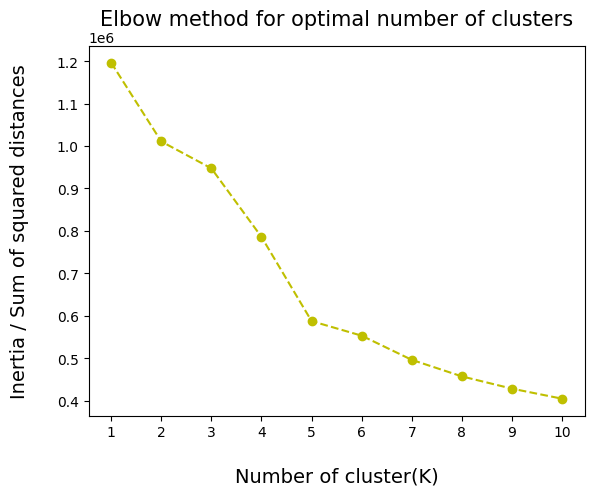

<Figure size 1400x800 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# Plot inertia values vs. number of clusters
plt.figure()
plt.xticks(range(1, max_clusters + 1))
plt.ylabel("Inertia / Sum of squared distances", fontsize=14, labelpad=20)
plt.xlabel("Number of cluster(K)", fontsize=14, labelpad=20)
plt.title("Elbow method for optimal number of clusters", fontsize=15, pad=15)
plt.plot([x for x in range(1, max_clusters + 1)], inertia_values, '--yo')
plt.figure(figsize=(14, 8))
plt.show()

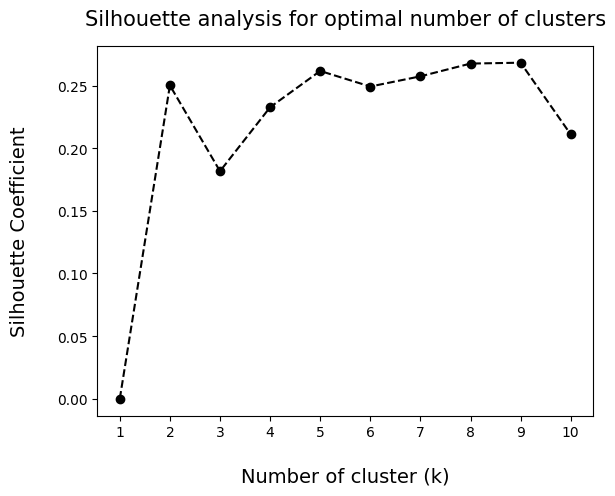

<Figure size 1400x800 with 0 Axes>

In [ ]:
# Plot silhouette scores vs. number of clusters
plt.figure()
plt.xticks(range(1, max_clusters + 1))
plt.ylabel("Silhouette Coefficient", fontsize=14, labelpad=20)
plt.xlabel("Number of cluster (k)", fontsize=14, labelpad=20)
plt.title("Silhouette analysis for optimal number of clusters", fontsize=15, pad=15)
plt.plot([x for x in range(1, max_clusters+1)], silhouette_values, '--ko')


# Set figure size
plt.figure(figsize=(14, 8))

plt.show()

#### **2.3.3 Run the algorithm on the data obtained from the dimensionality reduction.**

In [ ]:
k = 2  # Set the number of clusters
centroids, clusters = kmeans_MR(rdd, reduce_func, k, df_points, max_iters=10)

In [ ]:
print("Final Centroids:")
print(centroids[:2])  # Print only the first 5 elements for example

Final Centroids:
[[-1.94666162e-02  2.35364601e-01 -9.37584162e-01  1.83488596e-02
  -1.03084696e-02  9.78940399e-04 -1.84800278e-03 -4.55953646e-03
  -4.00573015e-03 -1.74789168e-02  1.65262341e-03 -5.36217773e-03
  -8.94318742e-04 -1.45126581e-02 -3.06838881e-02 -8.90706331e-02
  -2.02220492e-02 -5.35107125e-03]
 [ 3.57429758e-02 -4.33681846e-01  1.72635782e+00 -3.50858271e-02
   1.76897608e-02 -2.16342160e-03  3.34743620e-03  8.26594885e-03
   7.39410706e-03  3.20583098e-02 -3.06910835e-03  1.01344278e-02
   1.48482504e-03  2.66745985e-02  5.65045364e-02  1.63713500e-01
   3.69404443e-02  9.55957174e-03]]


 #### **2.3.4 Implement K-means++ from scratch and explain the differences with the results you got earlier.**

In [ ]:

def kmeans_plusplus_init(data, k):
    # Randomly choose the first centroid
    centroids = [data.sample().values[0]]

    # Choose the remaining centroids using the k-means++ algorithm
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x - c) ** 2 for c in centroids]) for x in data.values])
        probability_distribution = distances / distances.sum()
        cumulative_distribution = np.cumsum(probability_distribution)

        # Randomly choose a new centroid based on the distribution
        random_value = np.random.rand()
        new_centroid_index = np.searchsorted(cumulative_distribution, random_value)
        centroids.append(data.iloc[new_centroid_index].values)

    return np.array(centroids)

k = 2

initial_centroids = kmeans_plusplus_init(df_combined, k)
print("Initial Centroids:", initial_centroids)


Initial Centroids: [[ 0.56264246 -0.7852331  -1.3197366  -1.0245926   0.20697437 -0.21849713
  -0.03544913 -0.05461484  0.02062601 -0.19078393 -0.07300037 -0.12006661
  -0.13294959 -0.13249929  0.28486884 -0.17308116 -0.1049334   0.14038326]
 [-0.4371578  -1.0448529   2.1921785   0.9533956  -0.65859425 -0.0581505
  -0.27692035 -0.07412685  0.07507095  0.38421756 -0.14893024  0.0772543
   0.11811628  0.19999336  0.38140574  0.06215829 -0.11817028 -0.03469489]]


**Comparision of the results from K mean vs K mean ++**

- From Custom K-mean clustering algorithm , the obtained final centroids for cluster component k=2 , the values obtained are different from what we obtained from K-mean ++ algorithm as Initial centroid values.

This could be because that the final centroids are adjusted based on the distribution of data points and the iterative nature of the k-means algorithm. If the algorithm converges successfully, the final centroids should represent the centers of the clusters in the data. The initial centroids play a crucial role in the convergence and quality of the final clustering solution for the later algorithm implementation.

**Our observation while execution :**  We observe that the K-Mean ++ algorithm excute very fast than the K-Mean algorithm. This could be because of the above mentioned reason.

#### **2.3.5 Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?**



Upon giving the prompt to the LLM chatbot, we have few suggestions including DBSCAN , we are not considering it as it has been used in the Bonus part of the assignment. Instead we are opting for the Gaussian Mixture Model (GMM) clustering algorithm, was chosen for its flexibility in handling clusters with different shapes and orientations.

Unlike K-Means, GMM assumes that data points are generated from a mixture of Gaussian distributions, making it suitable for datasets where clusters may not exhibit spherical shapes. GMM provides probabilistic cluster assignments, assigning a likelihood score to each data point for belonging to a particular cluster, offering more nuanced information compared to the hard assignments of K-Means and DBSCAN. Additionally, GMM can handle clusters with varying shapes and sizes, providing greater flexibility.

The choice is grounded in the desire to introduce a probabilistic clustering method with the capability to capture uncertainty in cluster assignments, particularly beneficial for datasets with diverse and complex structures. Ultimately, the selection of GMM aims to explore the probabilistic nature of cluster assignments and its adaptability to diverse cluster structures.

In [ ]:
# Initializing a range of cluster numbers to test
n_components_range = range(1, 11)

# Initializing lists to store BIC and AIC values
bic_values = []
aic_values = []


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

datatest = df_combined.values

for n_components in n_components_range:
    # Fit GMM with current number of components
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(datatest)

    # Append BIC and AIC values to the lists
    bic_values.append(gmm.bic(datatest))
    aic_values.append(gmm.aic(datatest))


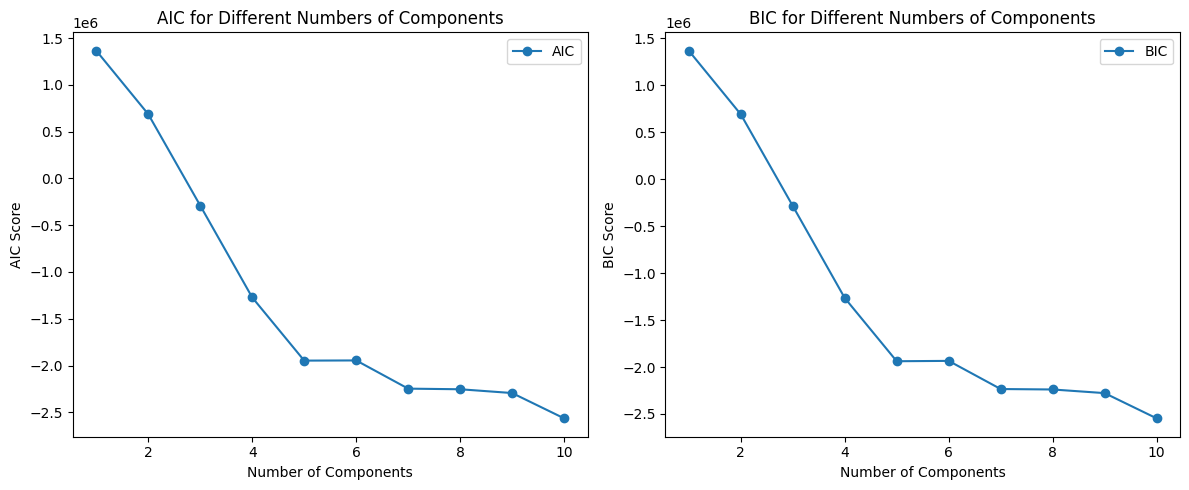

In [ ]:
# Create a subplot with two plots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot AIC values
ax1.plot(n_components_range, aic_values, label='AIC', marker='o')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('AIC Score')
ax1.set_title('AIC for Different Numbers of Components')
ax1.legend()

# Plot BIC values
ax2.plot(n_components_range, bic_values, label='BIC', marker='o')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('BIC Score')
ax2.set_title('BIC for Different Numbers of Components')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


For GMM, the AIC and BIC scores represent the relative complexity of the model compared to the likelihood of the data. A lower AIC or BIC score indicates a better fit to the data, but it also penalizes more complex models.

**Upon Examination:**

- the AIC and BIC scores are minimized at K=2. This suggests that the optimal number of clusters for the data is 2.

But comparing with the above implementation of K mean , the optimal cluster that we found is 2 , so to some extent the result given by gmm can be true.

## **2.4 Analysing your results!**

#### **2.4.1 Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.**

We are considering the features like 'total_clicks','distinct_genres_count','days_active' that we have created to select the 2-3 variables that are relevant to identify the cluster of customer.

We are justifying our reason for that as follows;

1.   **total_clicks:** Total clicks can serve as a measure of user engagement. Users who click more frequently are likely more active and engaged with the platform. High total clicks may indicate a more involved and interested user.

2.   **distinct_genres_count:** The diversity of genres a user interacts with can provide insights into their preferences and interests. Users with a higher count of distinct genres may have varied tastes, and this information can be valuable for understanding user behavior and tailoring recommendations or content.

3. **days_active:** The number of days a user is active is a measure of the user's consistency in using the platform. Users who are active on more days may exhibit more regular behavior.


In [ ]:
cluster_assignments = []
for i, cluster in enumerate(clusters):
    for point in cluster:
        cluster_assignments.append((point, i))

# Print the first 10 cluster assignments for each observation
lines_printed = 0
for point, cluster in cluster_assignments:
    if lines_printed < 10:
        print(f"Point {point} is assigned to Cluster {cluster}")
        lines_printed += 1
    else:
        break  # Stop printing after 10 lines


Point (32.37, 12.78, -0.49, 1.17, -0.82, 35.83, -0.29, 0.01, -0.03, 0.26, 0.23, 0.08, 0.02, -0.28, 0.31, -0.3, 0.27, 0.19) is assigned to Cluster 0
Point (103.13, 16.63, 0.35, 2.05, 2.42, -14.31, -0.25, -0.31, 0.18, -0.14, -0.11, 0.11, 0.16, 0.07, -0.17, -0.01, -0.08, 0.07) is assigned to Cluster 0
Point (84.37, 13.44, 0.05, 1.49, 2.01, -11.73, 0.02, 0.19, -0.13, -0.23, -0.17, 0.24, 0.14, -0.01, -0.21, -0.14, -0.15, 0.44) is assigned to Cluster 0
Point (28.49, 8.02, -0.66, 1.58, -0.14, 21.4, 0.03, 0.24, -0.09, -0.24, -0.25, 0.03, -0.17, -0.03, -0.0, -0.1, -0.06, -0.07) is assigned to Cluster 0
Point (72.48, 11.47, -0.03, 3.33, 0.93, -10.08, 0.94, -0.02, 0.15, 0.35, 0.39, -0.04, 0.3, 0.02, -0.04, -0.06, -0.28, -0.01) is assigned to Cluster 0
Point (20.51, 6.53, -0.87, -0.32, 0.06, 16.69, -0.32, 0.33, -0.06, -0.12, 0.49, 0.39, -0.12, 0.0, 0.04, -0.03, -0.07, -0.08) is assigned to Cluster 0
Point (17.94, 5.19, -0.06, 0.17, -0.15, 14.62, 0.21, 0.45, 0.37, -0.12, -0.11, -0.17, -0.19, 0.02, 

In [ ]:
dfn.index = dfn['user_id']

In [ ]:
dfn['cluster'] = [cluster for point, cluster in cluster_assignments]

In [ ]:
dfn['cluster'].head()

user_id
322abe045c    0
28afa6a44d    0
ea2b1ea81e    0
2863be3386    0
7fad36635f    0
Name: cluster, dtype: int64

In [ ]:
# Assuming dfn is your Pandas DataFrame
cluster_counts = dfn['cluster'].value_counts()

# Print the counts
print(cluster_counts)

0    69072
1    37519
Name: cluster, dtype: int64


In [ ]:
dfc = dfn.copy()

#### **2.4.2 Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.**

The entries in the total_clicks ranges from -0.385 to 129.471. To divide it into four categories , we will be using **pd.qcut** function to variables into four categories (quartiles) based on the specified quantile intervals.

In [ ]:
def create_category_column(data, column_name):

    # Define the bin edges for quartiles
    bin_edges = [0, 0.25, 0.5, 0.75, 1]

    new_column_name = f'Categories_{column_name}'
    data[new_column_name] = pd.qcut(data[column_name], bin_edges, labels=False, duplicates='drop') + 1


In [ ]:
create_category_column(dfc, "total_clicks")

In [ ]:
dfc['Categories_total_clicks'].head()

user_id
322abe045c    3
28afa6a44d    1
ea2b1ea81e    1
2863be3386    2
7fad36635f    1
Name: Categories_total_clicks, dtype: int64

In [ ]:
create_category_column(dfc, "distinct_genres_count")

In [ ]:
dfc['Categories_distinct_genres_count'].head()

user_id
322abe045c    2
28afa6a44d    1
ea2b1ea81e    1
2863be3386    1
7fad36635f    1
Name: Categories_distinct_genres_count, dtype: int64

In [ ]:
create_category_column(dfc, "days_active")

In [ ]:
dfc['Categories_days_active'].head()

user_id
322abe045c    2
28afa6a44d    1
ea2b1ea81e    1
2863be3386    2
7fad36635f    1
Name: Categories_days_active, dtype: int64

#### **2.4.3 With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.**

In [ ]:
dp1= dfc.pivot_table("total_clicks",["cluster"],["Categories_total_clicks"],aggfunc= {"Categories_total_clicks":"count"})
dp1

Categories_total_clicks,1,2,3
cluster,,,
0,37466,8919,22687
1,32827,2481,2211


In [ ]:
dp2= dfc.pivot_table("distinct_genres_count",["cluster"],["Categories_distinct_genres_count"],aggfunc= {"Categories_distinct_genres_count":"count"})
dp2

Categories_distinct_genres_count,1,2
cluster,,
0,53104,15968
1,36257,1262


In [ ]:
dp3=dfc.pivot_table("days_active",["cluster"],["Categories_days_active"],aggfunc= {"Categories_days_active":"count"})
dp3

Categories_days_active,1,2
cluster,,
0,44773,24299
1,35857,1662


#### **2.4.4 calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Time_Day variable:**

| Time_Day | Afternoon | Morning | Night |
|---|---|---|---|
| Cluster 1 | 3 | 94 | 3 |
| Cluster 2 | 83 | 5 | 12 |
| Cluster 3 | 16 | 10 | 74 |
| Cluster 4 | 34 | 18 | 48 |


In [ ]:
dp1_percentage = dp1.apply(lambda x: x / x.sum() * 100, axis=1)
dp1_percentage

Categories_total_clicks,1,2,3
cluster,,,
0,54.241950,12.912613,32.845437
1,87.494336,6.612650,5.893014


In [ ]:
dp2_percentage = dp2.apply(lambda x: x / x.sum() * 100, axis=1)
dp2_percentage

Categories_distinct_genres_count,1,2
cluster,,
0,76.882094,23.117906
1,96.636371,3.363629


In [ ]:
dp3_percentage = dp3.apply(lambda x: x / x.sum() * 100, axis=1)
dp3_percentage

Categories_days_active,1,2
cluster,,
0,64.820767,35.179233
1,95.570244,4.429756


# **3. Bonus Question**

Chat gpt suggest us as the three algorithms for density based clustering:  

-DBSCAN  
-OPTICS  
-HDBSCAN

After asking what are the strenghts and weaknesses of each of those we decided to go with DBSCAN, since it seems to be the faster and more suitable for a quite big dataset like the one we have. We tried also with OPTICS but the only way to get results in an acceptable time frame was using a sample coming from the original dataset.  
In order to decide the values of the parameters epsilon and min sample we tried to put several couples of values trying to minimize the number of points classified as noise and the amount of clusters since in a density based cluster analysis we don't choose the number of cluster.  
We want to classify as many points as possible into clusters but at the same time we don't want several houndred of clusters with a few units.  
While choosing the two variables for the plot axis we followed different approach, choosing in the end the one that seems to guaranteed the best representation.  
The first idea was to use the two variables with the highest variance since usually they should be the ones that most explain the cluster division. In this case the two variables are PCA1 and PCA2 because of how the PCA works, but the plot didn't show enough the cluster division. Then we tried checking which variables seemed more correlated among themselves and with the variable cluster labels, trying plotting the data on different couples of variables before
ending up on PCA5 and MCA2, the two variables with the highest negative correaltion that seemed to best suit the role.

Estimated number of clusters: 34
Estimated number of noise points: 42747
Cardinality of each cluster:
Cluster 0: 21343 points
Cluster 1: 6296 points
Cluster 2: 13708 points
Cluster 3: 809 points
Cluster 4: 1725 points
Cluster 5: 1369 points
Cluster 6: 343 points
Cluster 7: 1567 points
Cluster 8: 5979 points
Cluster 9: 2039 points
Cluster 10: 326 points
Cluster 11: 1464 points
Cluster 12: 605 points
Cluster 13: 387 points
Cluster 14: 656 points
Cluster 15: 1433 points
Cluster 16: 615 points
Cluster 17: 742 points
Cluster 18: 224 points
Cluster 19: 76 points
Cluster 20: 70 points
Cluster 21: 157 points
Cluster 22: 267 points
Cluster 23: 123 points
Cluster 24: 70 points
Cluster 25: 256 points
Cluster 26: 73 points
Cluster 27: 186 points
Cluster 28: 155 points
Cluster 29: 418 points
Cluster 30: 196 points
Cluster 31: 61 points
Cluster 32: 56 points
Cluster 33: 50 points


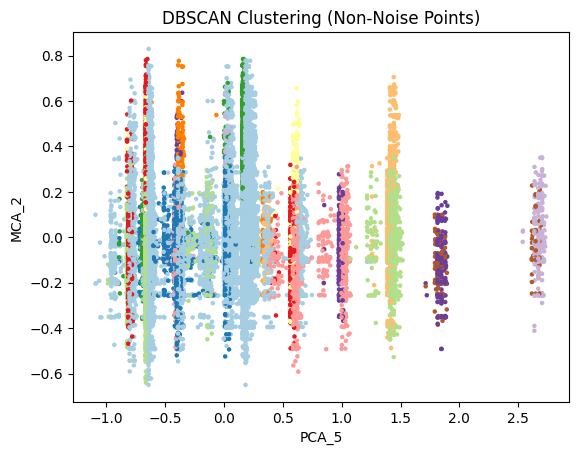

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


df = pd.read_csv('dimensionality_reduced_df.csv')

# Setting the parameters for the DBSCAN
# min_sample represent the minimum number of units a cluster must have in
# order to not be considered noise and eps is the maximum distance between
# two units for one to be considered as in the neighborhood of the other.
# We use euclidean distance as specified in metrics and n_jobs=-1 means that
# the algorithm uses all the core avaible making it significantly faster.

dbscan = DBSCAN(eps=0.6, min_samples=50, metric='euclidean',n_jobs=-1)

# Applying the algorithm

labels = dbscan.fit_predict(df)

# Adding cluster labels to the dataset

df['cluster_label'] = labels

# Identifing the subdataset of the noise points

noise_mask = labels == -1
noise_points = df[noise_mask]

# Identifing the subdataset of the non-noise points

non_noise_mask = labels != -1
non_noise_points = df[non_noise_mask]

# Printing the estimated number of clusters and of noise points

unique_labels, cluster_counts = np.unique(non_noise_points['cluster_label'], return_counts=True)
print(f'Estimated number of clusters: {len(unique_labels)}')
print(f'Estimated number of noise points: { len(noise_points)}')

# Printing the cardinality of each cluster

print("Cardinality of each cluster:")
for cluster_label in unique_labels:
    cluster_size = cluster_counts[cluster_label]
    print(f"Cluster {cluster_label}: {cluster_size} points")

# Plotting all the non-noise points

plt.scatter(non_noise_points['PCA_5'], non_noise_points['MCA_2'], c=labels[non_noise_mask], cmap = plt.get_cmap('Paired', 36), s=5)
plt.title('DBSCAN Clustering (Non-Noise Points)')
plt.xlabel('PCA_5')
plt.ylabel('MCA_2')
plt.show()

The number of clusters the algorithm finds is 36 while the number of noise points amount to 42591. They are quite a lot, more than a third of the dataset. By tweaking the parameters to acceptables value (obviusly if min_sample=1 or eps=1 all the points aren't going to be any noise but the results won't make much sense) we were able to lower them also below 30000 but in those case we either had way to many (100/200) very small cluster (if min_sampled was to low) or a very big cluster with 70% of the units and some very small ones (if eps was to high), so we decided to go with this configuration.  


Comparing this results with the ones in the previous question we can see how the number of clusters obtain withe the density based algorithm is way higher. In order to tune it down we could increase significantly the eps, but this would put us in the situation of having a very huge cluster and some small ones and this is not goint to be helpfull. The two approach are very different, while the k-means try to find k points that minimize the within variance of each cluster and maximize the variance between different clusters, the density based algorithm try to find areas where the point are more dense. This could mean that if enough points are in between two different points, even two very very far unit could be in the same cluster, and very close points could be in different ones.



# **4. Command Line Question**

I noticed that in the duration column we have an unacceptable row where it equals -1. I created a new csv without it.

In [ ]:
awk -F, '$3 != -1' vodclickstream_uk_movies_03.csv > movies.csv

## **4.1 Most viewed movie**

Through "cut -d ',' -f4" we take into account in our analysis only the fourth column i.e. that of the movie name for each row ("-d ',' " indicates that each column is separated by a delimiter of the type ',').

After that we sort it so that we have all the repetitions of each neighboring movie and through "uniq -c" we take unique values of the movie title and with "-c" count all the repetitions so as to find the most viewed movie.

We sort again in descending order according to the number of repeats of the movie with "sort -nr"; we take only the first row with "head -n 1" and print the full name of the movie via "awk '{print substr($0, index($0,$2))}' "


In [ ]:
most_viewed_movie=$(cut -d',' -f4 movies.csv | sort | uniq -c | sort -nr | head -n 1 | awk '{print substr($0, index($0,$2))}')
echo "The movie most viewed in Netflix UK is: $most_viewed_movie"


## **4.2 Average time between two clicks**

Here quite explicitly we take the third column of which we are going to average by summing the values present along with the count increment to get the total number of values summed.

I use the END statement so that I do not receive as printed output all the sum and count values every time there is an increment.

We then printed the actual average seen in hours because in seconds we had too large a number that does not render well the resulting amount of time.


In [ ]:
average_time=$(awk -F, '{print $3}' movies.csv | awk '{sum += $1; count += 1} END {print sum/count/3600}')
echo "Average duration between subsequent clicks: $average_time hours"

## **4.3 ID of the user that has spent the most time on Netflix**

In this case I create an array user_durations[] that with "$NF" takes the last column ever (I do not take the numbered column because the delimiter ',' is also present in some values like the title and so for each row the command splits the columns differently).

In this column it adds the durations to figure out for each user how much time they spent on Netflix. With the END statement we apply the next command at the end of the one just described.

We analyze the total duration of each user and compare it to the maximum duration we have (we start with a maximum duration of 0) and then print the user who spent the most time on Netflix.


In [ ]:
most_watcher_userID=$(awk -F, '{ user_duration[$NF]+=$3 } END { max_duration=0; for (user in user_duration) { if (user_duration[user] > max_duration) { max_duration = user_duration[user]; most_watcher_userID = user; } } print most_watcher_userID }' movies.csv)
echo "ID dell'utente che ha trascorso più tempo su Netflix: $most_watcher_userID"

all three has been executed in a single script called commandline.sh and the expected output is as follow;



# **5. Algorithmic Question**

a) A first implementation of the algorithm (it was decided to don't consider it a problem if at a given point of the algorithm some of the marks are below 0, so in this implementation marks can be negative).
The function is divided in two parts, the first reorder the marks in the way that maximize the last mark according to the university rule and the other one actually computes the maximum score.
To maximize the last mark the student wants to take the exam in any order such that there is an alternation between the half higher marks and the half lower ones, ending on one of the higher, this way we maximize the 'jumps' resulting in the last mark of the ordered list having the highest possible score it could have.

In [ ]:

import numpy as np
s=int(input())
p=list(map(int,input().split()))
def aq(s,p):
    p.sort()
    p1=p[0:int(np.floor(len(p)/2))]
    p2=p[int(np.floor(len(p)/2)):len(p)]
    #first we split the marks in two sublists, one with the half highest scores and one with the lowest
    pf=p
    i1=1
    i2=1
    for i in range(len(pf)):
        if i%2!=0:
            pf[-i-1]=p1[-i1]
            i1 +=1
        else:
            pf[-i-1]=p2[-i2]
            i2 +=1
    #then we alternate elements of the two sublists, making sure that the last one is one of the highest

    for _ in range(len(pf)):

            if len(pf)==1:
                return pf
            else:
                diff=s-pf[0]
                s=pf[0]
                pf=pf[1:]
                pf = [x + diff for x in pf]
    #then we apply the rule of the university




print(aq(s,p))



b) If we consider n=len(p), the sorting is O(nlogn),the splitting into p1 and p2 is O(n) as the first cicle and the second one is O(n^2) since it has a list comprension over n in the worst case. So the algorithm is O(n^2)

c) Using a recursive algorithm instead of the second loop and the list comprension makes it possible to create a faster and lighter version of the algorithm

In [ ]:
import numpy as np


def rec_aq(p, s, first_iteration=True):
    if len(p)<=1:
        return p #condition at which the recursion ends
    if first_iteration:
        #ordering the marks in the list p in the right order, it is needed only for the first recursion
        p.sort()
        p1=p[0:int(np.floor(len(p)/2))]
        p2=p[int(np.floor(len(p)/2)):len(p)]
        #first we split the marks in two sublists, one with the half highest scores and one with the lowest
        pf=p
        i1=1
        i2=1
        for i in range(len(pf)):
            if i%2!=0:
                pf[-i-1]=p1[-i1]
                i1 +=1
            else:
                pf[-i-1]=p2[-i2]
                i2 +=1
        #then we alternate elements of the two sublists, making sure that the last one is one of the highest
    else:
        pf=p


    diff = s - pf[0]
    pf[1:] = [x + diff for x in pf[1:]]


    return  rec_aq(pf[1:], pf[0], first_iteration=False)
    #implementation with recursion of the university rule



s = int(input())
p = list(map(int, input().split()))
print(rec_aq(p, s))


The sorting, that always takes O(nlogn) happens only one time in the first iteration and so the splitting and the loop that are O(n). For the recursive part, we have to analize the depth and the cost of each new call of the function. The depth is n since every time we repeat the function with a vector that is smaller by one element, while the cost of each recursion is costant(since it doesn't have to repeat neither the sorting or the loop the algorithm repeat in the worst case only the condition and the three operation before the recursive call) so the recursion is nO(4)=O(n). So in the end the O(nlogn) is the computational time of this algorithm which is indeed less than before.

d) After having asked to chatgpt to optimize the function even further it suggest me to use np.median to divide the mark list in the two sublists without having to sort it (since the sorting was the slowest part).
According to chatgpt np.median in the average case is close to O(n), but in the worst case is always O(nlogn). While talking about computational time we have to consider the worst scenario, that in our case is equal for the two algorithms, but being able to do the task in linear time O(n) on average seems a good enough results to include the new version of the algorithm.

In [ ]:
import numpy as np


def rec_aq_chatgpt(p, s, first_iteration=True):
    if len(p)<=1:
        return p #condition at which the recursion ends
    if first_iteration:
        #ordering the marks in the list p in the right order, it is needed only for the first recursion
        pivot = np.median(p)

        # Partition the array
        p1 = [x for x in p if x < pivot]
        p2 = [x for x in p if x >= pivot]

        #first we split the marks in two sublists, one with the half highest scores and one with the lowest
        pf=p
        i1=1
        i2=1
        for i in range(len(pf)):
            if i%2!=0:
                pf[-i-1]=p1[-i1]
                i1 +=1
            else:
                pf[-i-1]=p2[-i2]
                i2 +=1
        #then we alternate elements of the two sublists, making sure that the last one is one of the highest
    else:
        pf=p


    diff = s - pf[0]
    pf[1:] = [x + diff for x in pf[1:]]


    return  rec_aq_chatgpt(pf[1:], pf[0], first_iteration=False)
    #implementation with recursion of the university rule



s = int(input())
p = list(map(int, input().split()))
print(rec_aq_chatgpt(p, s))